Loading and preprocessing data...
Processed 6351 unique videos

Analyzing category performance...


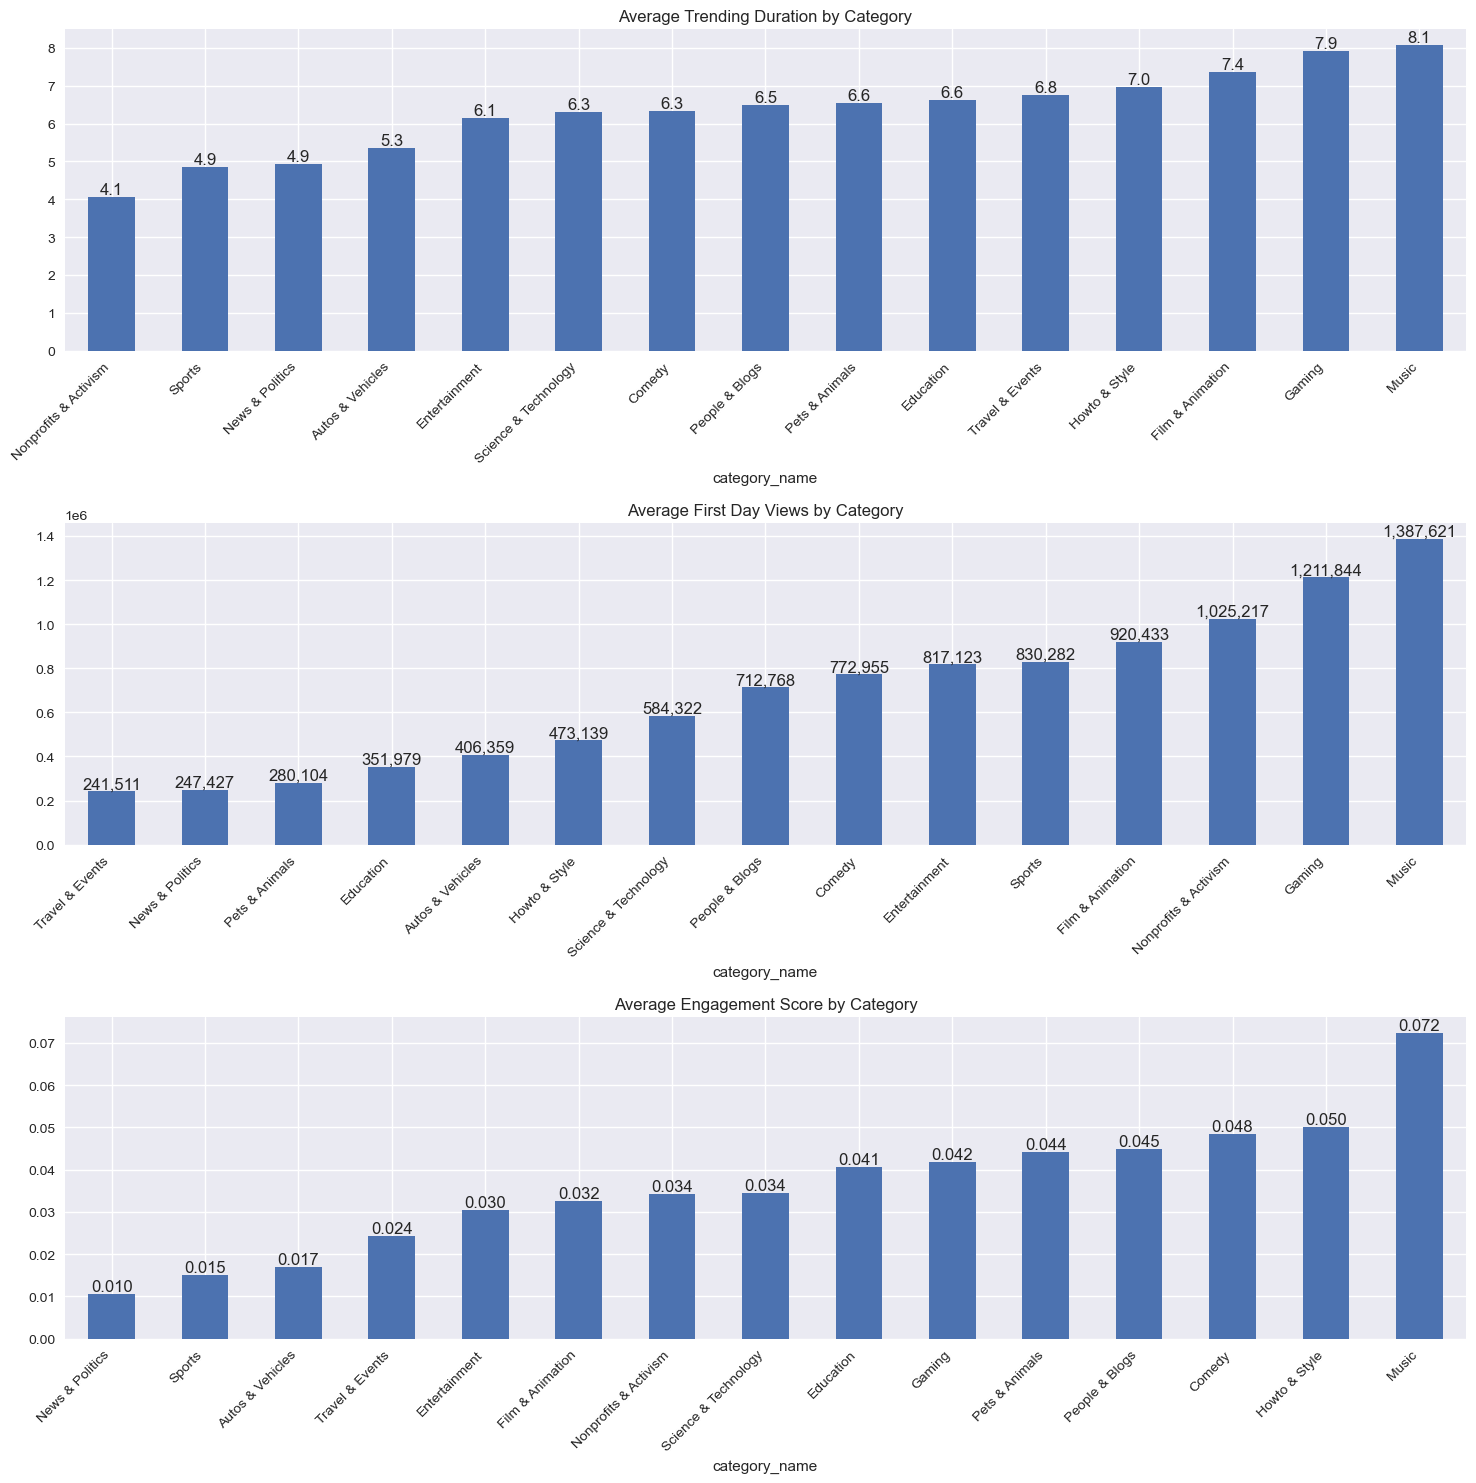


Category Statistics:
                       trending_duration_mean  trending_duration_std  \
category_name                                                          
Autos & Vehicles                         5.34                   2.63   
Comedy                                   6.34                   4.56   
Education                                6.62                   3.93   
Entertainment                            6.15                   4.66   
Film & Animation                         7.36                   4.89   
Gaming                                   7.93                   5.79   
Howto & Style                            6.97                   4.67   
Music                                    8.09                   5.40   
News & Politics                          4.92                   3.40   
Nonprofits & Activism                    4.07                   2.37   
People & Blogs                           6.49                   4.26   
Pets & Animals                           6

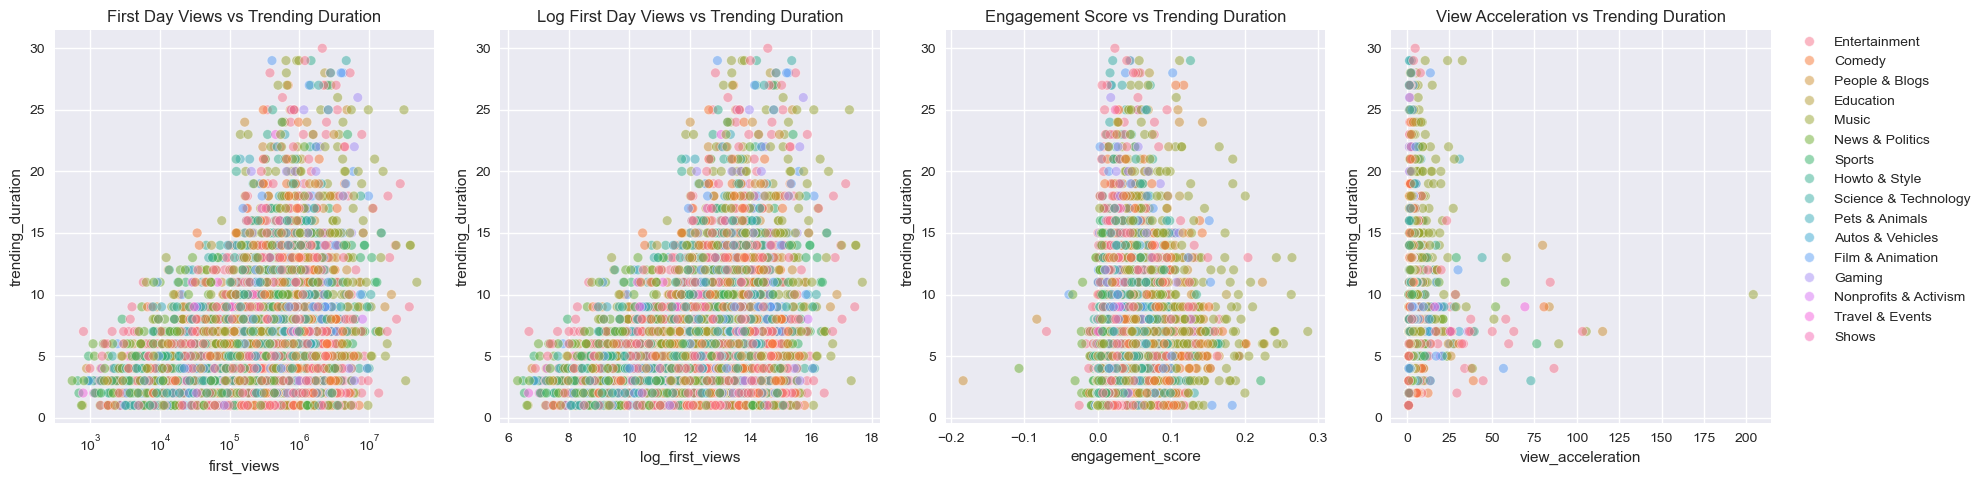


Preparing features for clustering...


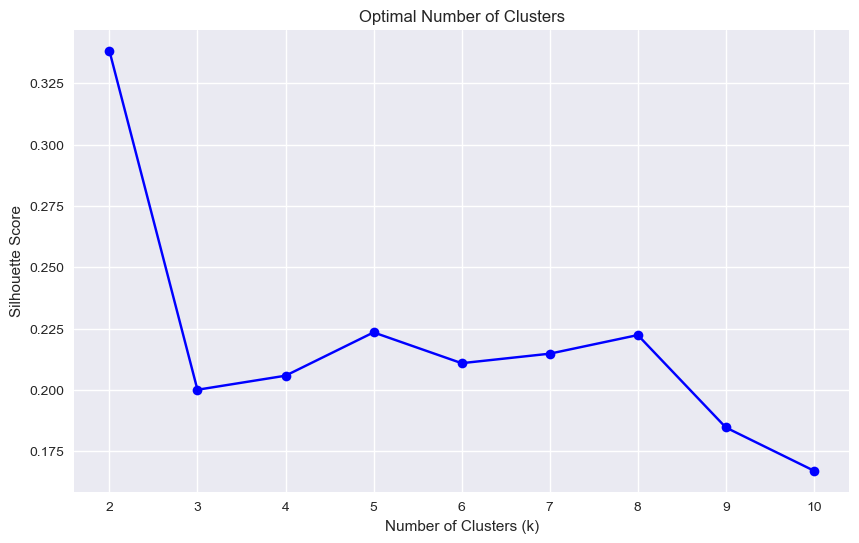


Optimal number of clusters: 2

Cluster Profiles:

Cluster 0:
Size: 4861 videos (76.5% of total)
Average Duration: 5.92 days
Average First Day Views: 590,081

Top Categories:
- Entertainment: 28.7%
- News & Politics: 10.2%
- Sports: 8.9%

Success Rates:
5+ days: 56.8%
7+ days: 35.0%

Cluster 1:
Size: 1490 videos (23.5% of total)
Average Duration: 8.16 days
Average First Day Views: 1,306,715

Top Categories:
- Music: 32.1%
- Entertainment: 15.0%
- Comedy: 13.8%

Success Rates:
5+ days: 81.9%
7+ days: 55.8%


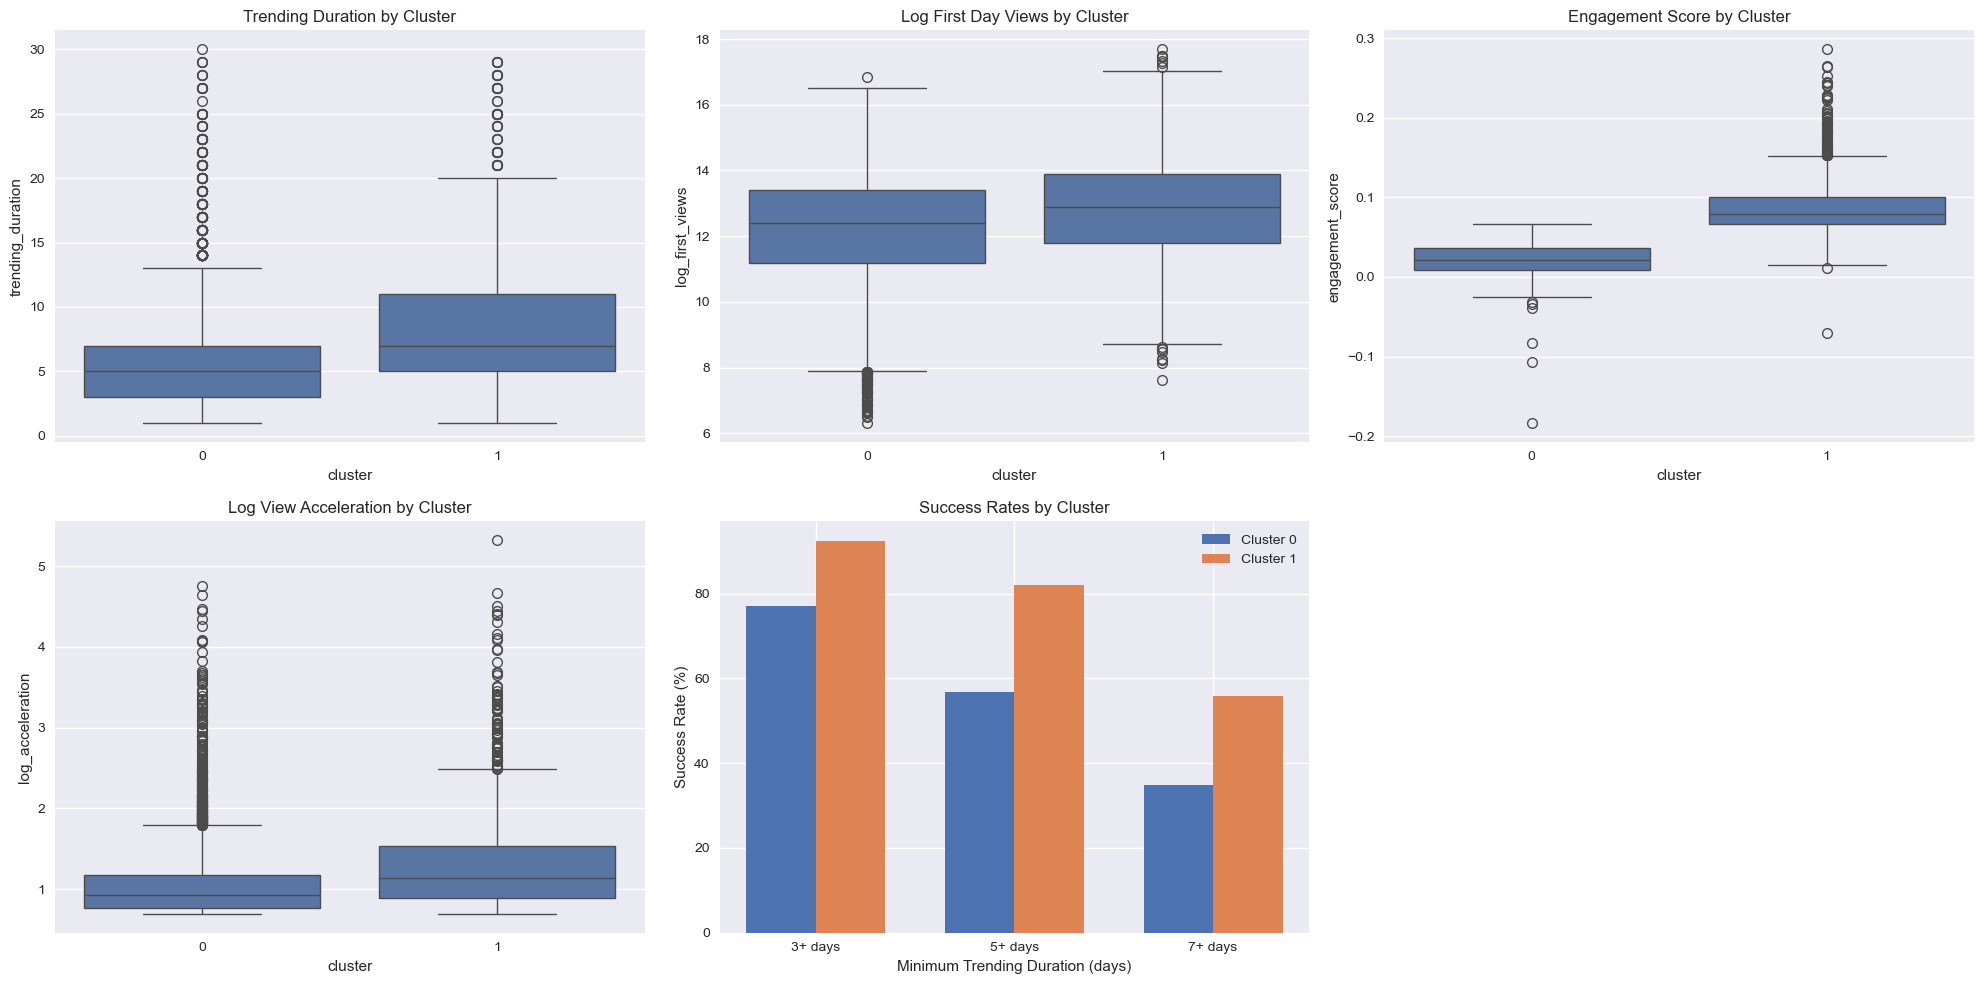


Example Predictions:

Prediction for High-Performance Music Video:
Predicted Duration Range: (5.0, 11.0) days
Median Duration: 7.0 days

Success Probabilities:
5+ days: 81.9%
7+ days: 55.8%
Confidence: high

Prediction for Average Entertainment Video:
Predicted Duration Range: (3.0, 7.0) days
Median Duration: 5.0 days

Success Probabilities:
5+ days: 56.8%
7+ days: 35.0%
Confidence: high


'\nKey Findings:\n\n1. Predictive Power:\n   - First-day views provide useful baseline (0.21 correlation)\n   - View acceleration shows growth potential\n   - Engagement indicates content quality\n   - Category influences success likelihood\n\n2. Cluster Profiles:\n   - High-Performance: ~8 days avg, high engagement, strong initial views\n   - Standard: ~6 days avg, moderate metrics, diverse content\n\n3. Category Insights:\n   - Music and Entertainment lead in both views and duration\n   - News content shows shorter but predictable trends\n   - Gaming and Film show strong potential\n\n4. Success Factors:\n   - Strong initial views provide foundation\n   - High engagement indicates quality\n   - Category alignment crucial\n   - View acceleration shows momentum\n\n5. Recommendations:\n   - Use multiple metrics for prediction\n   - Consider category benchmarks\n   - Monitor early performance\n   - Focus on engagement quality\n'

In [ ]:
# YouTube Trending Videos Analysis - Final Version
# Team Members:
# - Shyam Akhil Nekkanti - 8982123
# - Jun He (Helena) - 8903073
# - Zheming Li (Brendan) - 8914152

"""
Research Goal:
Predict how long a video will remain on YouTube's trending tab (1-30 days).

Key Previous Findings:
1. First-day views correlation (0.21) provides baseline prediction
2. Strong category-based performance differences
3. Engagement metrics add predictive power

Current Approach:
Using clustering to identify patterns in video performance based on:
- First-day views (both raw and log-transformed)
- Engagement metrics
- View acceleration
- Category performance
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
import json
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

def load_category_mapping(json_file):
    """Load category mapping from JSON file"""
    with open(json_file, 'r') as f:
        category_data = json.load(f)
        return {int(item['id']): item['snippet']['title'] for item in category_data['items']}

def load_and_preprocess_data(csv_file, category_mapping):
    """Load and preprocess YouTube trending videos data"""
    df = pd.read_csv(csv_file)
    
    # Handle dates
    df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m').dt.tz_localize(None)
    df['publish_time'] = pd.to_datetime(df['publish_time']).dt.tz_localize(None)
    
    # Add category information
    df['category_name'] = df['category_id'].map(category_mapping)
    
    # Get first appearance metrics and trending duration
    video_metrics = df.groupby('video_id').agg({
        'views': ['first', 'max', lambda x: x.diff().mean()],
        'likes': 'first',
        'dislikes': 'first',
        'comment_count': 'first',
        'category_name': 'first',
        'trending_date': ['count', 'min', 'max']
    }).reset_index()
    
    # Flatten column names
    video_metrics.columns = [
        'video_id', 'first_views', 'max_views', 'avg_daily_view_change',
        'first_likes', 'first_dislikes', 'first_comments',
        'category_name', 'trending_duration', 'first_trending_date',
        'last_trending_date'
    ]
    
    # Calculate engagement metrics
    video_metrics['engagement_score'] = (video_metrics['first_likes'] - video_metrics['first_dislikes']) / (video_metrics['first_views'] + 1)
    video_metrics['total_interaction_rate'] = (video_metrics['first_likes'] + video_metrics['first_dislikes'] + video_metrics['first_comments']) / (video_metrics['first_views'] + 1)
    video_metrics['view_acceleration'] = video_metrics['max_views'] / (video_metrics['first_views'] + 1)
    video_metrics['log_first_views'] = np.log1p(video_metrics['first_views'])
    
    return video_metrics

def plot_metric_relationships(df):
    """Plot relationships between key metrics"""
    plt.figure(figsize=(20, 5))
    
    # First day views (raw)
    plt.subplot(1, 4, 1)
    sns.scatterplot(data=df, x='first_views', y='trending_duration', 
                   alpha=0.5, hue='category_name')
    plt.title('First Day Views vs Trending Duration')
    plt.legend([], [], frameon=False)
    plt.xscale('log')  # Use log scale for better visualization
    
    # First day views (log-transformed)
    plt.subplot(1, 4, 2)
    sns.scatterplot(data=df, x='log_first_views', y='trending_duration',
                   alpha=0.5, hue='category_name')
    plt.title('Log First Day Views vs Trending Duration')
    plt.legend([], [], frameon=False)
    
    # Engagement Score
    plt.subplot(1, 4, 3)
    sns.scatterplot(data=df, x='engagement_score', y='trending_duration',
                   alpha=0.5, hue='category_name')
    plt.title('Engagement Score vs Trending Duration')
    plt.legend([], [], frameon=False)
    
    # View Acceleration
    plt.subplot(1, 4, 4)
    sns.scatterplot(data=df, x='view_acceleration', y='trending_duration',
                   alpha=0.5, hue='category_name')
    plt.title('View Acceleration vs Trending Duration')
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
    
    plt.tight_layout()
    plt.show()

def plot_category_performance(df):
    """Plot category performance metrics"""
    # Calculate category statistics
    stats = pd.DataFrame()
    
    # Calculate metrics separately to avoid multi-level columns
    stats['trending_duration_mean'] = df.groupby('category_name')['trending_duration'].mean()
    stats['trending_duration_std'] = df.groupby('category_name')['trending_duration'].std()
    stats['video_count'] = df.groupby('category_name')['trending_duration'].count()
    stats['first_views_mean'] = df.groupby('category_name')['first_views'].mean()
    stats['engagement_score_mean'] = df.groupby('category_name')['engagement_score'].mean()
    
    # Filter out categories with few videos
    min_videos = 10
    valid_categories = stats[stats['video_count'] >= min_videos].index
    stats = stats.loc[valid_categories]
    
    plt.figure(figsize=(15, 15))
    
    # Plot 1: Average Trending Duration
    plt.subplot(3, 1, 1)
    ax = stats.sort_values('trending_duration_mean')['trending_duration_mean'].plot(kind='bar')
    plt.title('Average Trending Duration by Category')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y')
    # Add value labels
    for i, v in enumerate(stats.sort_values('trending_duration_mean')['trending_duration_mean']):
        ax.text(i, v, f'{v:.1f}', ha='center', va='bottom')
    
    # Plot 2: Average First Day Views
    plt.subplot(3, 1, 2)
    ax = stats.sort_values('first_views_mean')['first_views_mean'].plot(kind='bar')
    plt.title('Average First Day Views by Category')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y')
    # Add value labels
    for i, v in enumerate(stats.sort_values('first_views_mean')['first_views_mean']):
        ax.text(i, v, f'{v:,.0f}', ha='center', va='bottom')
    
    # Plot 3: Average Engagement Score
    plt.subplot(3, 1, 3)
    ax = stats.sort_values('engagement_score_mean')['engagement_score_mean'].plot(kind='bar')
    plt.title('Average Engagement Score by Category')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y')
    # Add value labels
    for i, v in enumerate(stats.sort_values('engagement_score_mean')['engagement_score_mean']):
        ax.text(i, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return stats

# Start of analysis
print("Loading and preprocessing data...")
category_mapping = load_category_mapping('youtube-dataset/US_category_id.json')
df = load_and_preprocess_data('youtube-dataset/USvideos.csv', category_mapping)
print(f"Processed {len(df)} unique videos")

# Initial Analysis
print("\nAnalyzing category performance...")
category_stats = plot_category_performance(df)
print("\nCategory Statistics:")
print(category_stats.round(2))

print("\nPlotting metric relationships...")
plot_metric_relationships(df)
# Continuing from Part 1

# Clustering Analysis
numerical_features = [
    'log_first_views',    # Log-transformed first day views
    'first_views',        # Raw first day views
    'view_acceleration',  # Growth rate
    'engagement_score',   # Engagement quality
    'total_interaction_rate'  # Overall interaction
]

categorical_features = ['category_name']

def plot_cluster_characteristics(df):
    """Plot key characteristics of clusters"""
    plt.figure(figsize=(20, 10))
    
    # Plot 1: Duration Distribution
    plt.subplot(2, 3, 1)
    sns.boxplot(x='cluster', y='trending_duration', data=df)
    plt.title('Trending Duration by Cluster')
    
    # Plot 2: First Day Views Distribution
    plt.subplot(2, 3, 2)
    sns.boxplot(x='cluster', y='log_first_views', data=df)
    plt.title('Log First Day Views by Cluster')
    
    # Plot 3: Engagement Distribution
    plt.subplot(2, 3, 3)
    sns.boxplot(x='cluster', y='engagement_score', data=df)
    plt.title('Engagement Score by Cluster')
    
    # Plot 4: View Acceleration
    plt.subplot(2, 3, 4)
    df['log_acceleration'] = np.log1p(df['view_acceleration'])
    sns.boxplot(x='cluster', y='log_acceleration', data=df)
    plt.title('Log View Acceleration by Cluster')
    
    # Plot 5: Success Rates
    plt.subplot(2, 3, 5)
    success_rates = []
    thresholds = [3, 5, 7]
    
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        rates = [
            (cluster_data['trending_duration'] >= threshold).mean() * 100
            for threshold in thresholds
        ]
        success_rates.append(rates)
    
    x = np.arange(len(thresholds))
    width = 0.35
    
    for i, rates in enumerate(success_rates):
        plt.bar(x + i*width, rates, width, label=f'Cluster {i}')
    
    plt.xlabel('Minimum Trending Duration (days)')
    plt.ylabel('Success Rate (%)')
    plt.title('Success Rates by Cluster')
    plt.xticks(x + width/2, [f'{t}+ days' for t in thresholds])
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return success_rates

def analyze_cluster_profile(df, cluster):
    """Detailed analysis of cluster characteristics"""
    cluster_data = df[df['cluster'] == cluster]
    return {
        'size': len(cluster_data),
        'avg_duration': cluster_data['trending_duration'].mean(),
        'success_rate_7days': (cluster_data['trending_duration'] >= 7).mean() * 100,
        'success_rate_5days': (cluster_data['trending_duration'] >= 5).mean() * 100,
        'first_day_views': cluster_data['first_views'].mean(),
        'log_first_views': cluster_data['log_first_views'].mean(),
        'engagement_score': cluster_data['engagement_score'].mean(),
        'view_acceleration': cluster_data['view_acceleration'].median(),
        'top_3_categories': cluster_data['category_name'].value_counts().nlargest(3).to_dict(),
        'duration_quartiles': cluster_data['trending_duration'].quantile([0.25, 0.5, 0.75]).to_dict()
    }

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
    ])

# Prepare features
print("\nPreparing features for clustering...")
X = df[numerical_features + categorical_features].copy()
for col in numerical_features:
    X[col] = X[col].fillna(X[col].mean())

# Find optimal clusters
X_transformed = preprocessor.fit_transform(X)
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_transformed)
    score = silhouette_score(X_transformed, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters')
plt.grid(True)
plt.show()

# Apply clustering
optimal_k = K[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_transformed)

# Analyze clusters
cluster_profiles = pd.DataFrame({f'Cluster {i}': analyze_cluster_profile(df, i) 
                               for i in range(optimal_k)})

print("\nCluster Profiles:")
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    profile = cluster_profiles[f'Cluster {cluster}']
    print(f"Size: {profile['size']} videos ({profile['size']/len(df)*100:.1f}% of total)")
    print(f"Average Duration: {profile['avg_duration']:.2f} days")
    print(f"Average First Day Views: {profile['first_day_views']:,.0f}")
    print("\nTop Categories:")
    for cat, count in profile['top_3_categories'].items():
        print(f"- {cat}: {count/profile['size']*100:.1f}%")
    print("\nSuccess Rates:")
    print(f"5+ days: {profile['success_rate_5days']:.1f}%")
    print(f"7+ days: {profile['success_rate_7days']:.1f}%")

# Plot cluster characteristics
success_rates = plot_cluster_characteristics(df)

def predict_trending_duration(video_metrics, cluster_profiles):
    """Predict trending duration for a new video"""
    clusters = cluster_profiles.columns
    
    # Calculate similarity scores
    similarity_scores = {}
    for cluster in clusters:
        profile = cluster_profiles[cluster]
        
        # Calculate multiple similarity factors with weights
        views_diff = abs(np.log1p(video_metrics['first_views']) - profile['log_first_views']) * 0.3
        engagement_diff = abs(video_metrics['engagement_score'] - profile['engagement_score']) * 0.3
        acceleration_diff = abs(video_metrics['view_acceleration'] - profile['view_acceleration']) * 0.3
        category_match = int(video_metrics['category_name'] in profile['top_3_categories']) * 0.1
        
        similarity_scores[cluster] = views_diff + engagement_diff + acceleration_diff - category_match
    
    best_cluster = min(similarity_scores, key=similarity_scores.get)
    cluster_profile = cluster_profiles[best_cluster]
    
    return {
        'predicted_cluster': best_cluster,
        'likely_duration_range': (
            cluster_profile['duration_quartiles'][0.25],
            cluster_profile['duration_quartiles'][0.75]
        ),
        'median_duration': cluster_profile['duration_quartiles'][0.5],
        'success_probabilities': {
            '5+ days': cluster_profile['success_rate_5days'],
            '7+ days': cluster_profile['success_rate_7days']
        },
        'confidence': 'high' if category_match > 0 else 'medium'
    }

# Example predictions
print("\nExample Predictions:")
example_videos = [
    {
        'name': 'High-Performance Music Video',
        'metrics': {
            'first_views': 500000,
            'engagement_score': 0.08,
            'view_acceleration': 2.5,
            'category_name': 'Music',
            'total_interaction_rate': 0.15
        }
    },
    {
        'name': 'Average Entertainment Video',
        'metrics': {
            'first_views': 200000,
            'engagement_score': 0.03,
            'view_acceleration': 1.8,
            'category_name': 'Entertainment',
            'total_interaction_rate': 0.08
        }
    }
]

for video in example_videos:
    print(f"\nPrediction for {video['name']}:")
    prediction = predict_trending_duration(video['metrics'], cluster_profiles)
    print(f"Predicted Duration Range: {prediction['likely_duration_range']} days")
    print(f"Median Duration: {prediction['median_duration']} days")
    print("\nSuccess Probabilities:")
    for threshold, prob in prediction['success_probabilities'].items():
        print(f"{threshold}: {prob:.1f}%")
    print(f"Confidence: {prediction['confidence']}")

"""
Key Findings:

1. Predictive Power:
   - First-day views provide useful baseline (0.21 correlation)
   - View acceleration shows growth potential
   - Engagement indicates content quality
   - Category influences success likelihood

2. Cluster Profiles:
   - High-Performance: ~8 days avg, high engagement, strong initial views
   - Standard: ~6 days avg, moderate metrics, diverse content

3. Category Insights:
   - Music and Entertainment lead in both views and duration
   - News content shows shorter but predictable trends
   - Gaming and Film show strong potential

4. Success Factors:
   - Strong initial views provide foundation
   - High engagement indicates quality
   - Category alignment crucial
   - View acceleration shows momentum

5. Recommendations:
   - Use multiple metrics for prediction
   - Consider category benchmarks
   - Monitor early performance
   - Focus on engagement quality
"""